# r-tree spatial indexing with Python and geopandas

This demo uses [OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/) and [geopandas](http://geoffboeing.com/2014/09/using-geopandas-windows/) to quickly find points within a polygon using an r-tree spatial index

In [1]:
import osmnx as ox, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline

## First example
### Create a polygon for the boundary of a city, and points representing street intersections around it

In [2]:
# get the boundary of some city
gdf = ox.gdf_from_place('Walnut Creek, California, USA')

In [3]:
# get the street network within this bounding box
west, south, east, north = gdf.unary_union.buffer(0.1).bounds
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', retain_all=True)

In [4]:
# get lat-long points for each intersection
xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
x, y = list(zip(*xy))

In [5]:
# turn the lat-long points into a geodataframe
gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y})
gdf_nodes.crs = gdf.crs
gdf_nodes.name = 'nodes'
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)

In [6]:
# make the geometry a multipolygon if it's not already
geometry = gdf['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

### Got the data, now visualize the points and the polygon

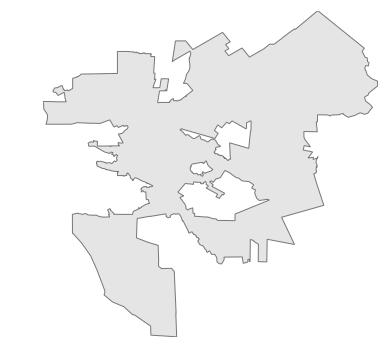

In [7]:
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

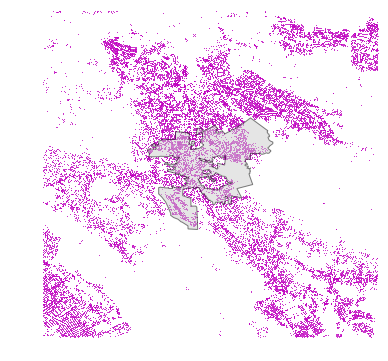

In [8]:
# plot the intersections and the city
west, south, east, north = gdf_nodes.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Create a spatial index and find the points within the polygon

In [9]:
sindex = gdf_nodes.sindex
possible_matches_index = list(sindex.intersection(geometry.bounds))
possible_matches = gdf_nodes.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(geometry)]

In [10]:
points_within_geometry = precise_matches
points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]

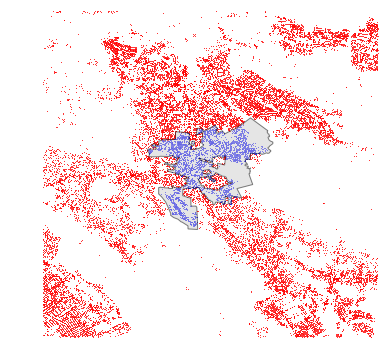

In [11]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

## Another Example

What if the points and polygon have the same bounding box? Because the polygon's minimum bounding box is the same as the set of points' minimum bounding box, r-tree considers every point to be a possible match. Thus, using an r-tree spatial index makes the intersection run no faster than it would without the spatial index.

Instead, we'll divide the polygon up into small sub-polygons, then using the spatial index to find which points possibly intersect with each of these sub-polygons. This method successfully finds fewer possible matches because each of the sub-polygons' minimum bounding boxes is much smaller than the set of points minimum bounding box.

Problem: when the polygon's bounding box is the same as the set of points', r-tree identifies every point as a possible match, thus offering no speed up. When coupled with lots of points and a polygon with lots of vertices, the intersection process is very slow. Example: the City of Los Angeles might take 20+ minutes.

Solution: wrote a quadrat routine to divide the polygon into sub-polygons. Then, for each sub-polygon, intersect it first with the points' r-tree index to get a small set of possible matches, then intersect those possible matches with the sub-polygon to get the set of precise matches. This brings computation time from 20+ minutes to a few seconds.

### Create a polygon for the boundary of a city, and points representing street intersections around it

In [12]:
# get the boundary of some city
gdf = ox.gdf_from_place('Los Angeles, California, USA')

In [13]:
# get the street network within this bounding box
west, south, east, north = gdf.unary_union.bounds
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', retain_all=True)

In [14]:
# get lat-long points for each intersection
xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
x, y = list(zip(*xy))

In [15]:
# turn the lat-long points into a geodataframe
gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y})
gdf_nodes.crs = gdf.crs
gdf_nodes.name = 'nodes'
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)
west, south, east, north = gdf_nodes.unary_union.bounds

In [16]:
# make the geometry a multipolygon if it's not already
geometry = gdf['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

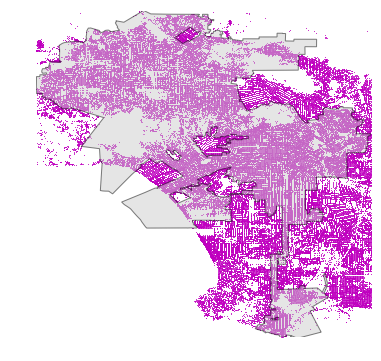

In [17]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Cut the polygon with quadrats into sub-polygons

In [18]:
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=0.1)

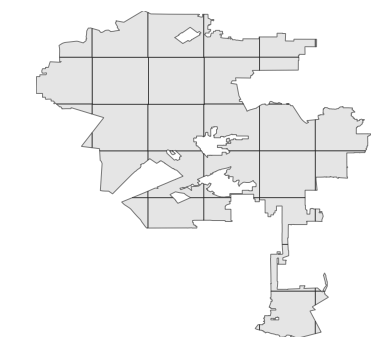

In [19]:
# plot the city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

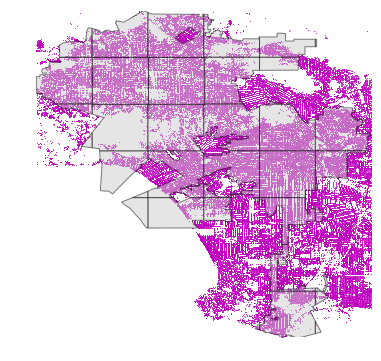

In [20]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Create a spatial index and find points within the sub-polygons

In [21]:
# build the r-tree index
sindex = gdf_nodes.sindex

In [22]:
# find the points that intersect with each subpolygon and add them to points_within_geometry
points_within_geometry = pd.DataFrame()
for poly in geometry_cut:
    # buffer by the <1 micron dist to account for any space lost in the quadrat cutting
    # otherwise may miss point(s) that lay directly on quadrat line
    poly = poly.buffer(1e-14).buffer(0)

    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = gdf_nodes.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    points_within_geometry = points_within_geometry.append(precise_matches)

In [23]:
# drop duplicate points, if buffered poly caused an overlap on point(s) that lay directly on a quadrat line
points_within_geometry = points_within_geometry.drop_duplicates(subset=['x', 'y'])
points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]

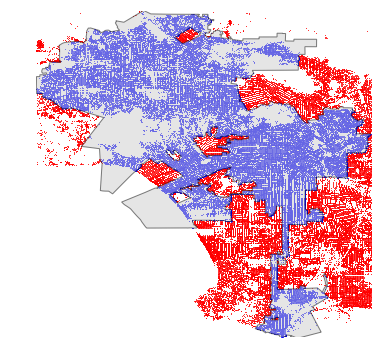

In [24]:
# plot the city and points within/outside
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()